# Chapter 4


## Validation strategies


In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Using TensorFlow backend.


In [0]:
# Load the IMDB dataset as an example
# I have to overwrite np.load as keras hasn't kept pace with the latest version of numpy
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=10000)

np.load = old
del(old)

# We can't feed variable-length lists of integers into our network (apparently),
# so one-hot encode each integer as a vector of 0s with a 1 at the index of the integer  

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [0]:
def build_model(dimension=10000):
  """
  Create a model with two hidden layers, each with 64 units.
  """
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(16, activation="relu", input_shape=(dimension,)))
  model.add(keras.layers.Dense(16, activation="relu"))
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
  return model

### Simple hold-out validation


In [36]:



num_validation_samples = 10000

np.random.shuffle(X_train)

X_val = X_train[:num_validation_samples]
partial_X_train = X_train[num_validation_samples:]
y_val = y_train[:num_validation_samples]
partial_y_train = y_train[num_validation_samples:]


model = build_model()

# Train on the training data, evaluate on the validation data
history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=10,
                   batch_size=512,
                   validation_data=(X_val, y_val))

# Once the parameters are sorted, train the final model from scratch on all non-test data

model = build_model()
model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=0)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 5s 309us/step - loss: 0.6937 - acc: 0.4958 - val_loss: 0.6937 - val_acc: 0.4946
Epoch 2/10
15000/15000 [==============================] - 2s 139us/step - loss: 0.6842 - acc: 0.5689 - val_loss: 0.6951 - val_acc: 0.4991
Epoch 3/10
15000/15000 [==============================] - 2s 136us/step - loss: 0.6513 - acc: 0.6473 - val_loss: 0.7090 - val_acc: 0.5022
Epoch 4/10
15000/15000 [==============================] - 2s 136us/step - loss: 0.5954 - acc: 0.7117 - val_loss: 0.7322 - val_acc: 0.5017
Epoch 5/10
15000/15000 [==============================] - 2s 135us/step - loss: 0.5418 - acc: 0.7471 - val_loss: 0.7876 - val_acc: 0.5004
Epoch 6/10
15000/15000 [==============================] - 2s 135us/step - loss: 0.4896 - acc: 0.7889 - val_loss: 0.8195 - val_acc: 0.5015
Epoch 7/10
15000/15000 [==============================] - 2s 137us/step - loss: 0.4442 - acc: 0.8165 - val_loss: 0.8298 - 

### K-fold validation
Split the data into K partitions of equal size: Train on K-1 partitions,validation on the other. Final score is the average over the K scores. 

In [21]:
# K-fold
k=4
num_val_samples = len(X_train) // k
num_epochs = 10

validation_scores = []

for i in range(k):
  print(f"processing fold {i}")
  val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
  
  partial_train_data = np.concatenate(
    [X_train[:i*num_val_samples],
     X_train[(i+1)*num_val_samples:]
    ],
    axis=0      
  )
  partial_train_targets = np.concatenate(
    [y_train[:i*num_val_samples],
     y_train[(i+1)*num_val_samples:]
    ],
    axis=0      
  )
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
           epochs=num_epochs, batch_size=512, verbose=0)
  val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
  validation_scores.append(val_acc)
  
validation_score = np.average(validation_scores)
print(validation_score)
# Once tuned, train on all data and evaluate
model = build_model()
model.fit(X_train, y_train, epochs=num_epochs, batch_size=512)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
0.4996800000095367
Epoch 1/10
25000/25000 [==============================] - 4s 158us/step - loss: 0.6935 - acc: 0.5048
Epoch 2/10
25000/25000 [==============================] - 2s 95us/step - loss: 0.6799 - acc: 0.5808
Epoch 3/10
25000/25000 [==============================] - 2s 97us/step - loss: 0.6431 - acc: 0.6440
Epoch 4/10
25000/25000 [==============================] - 2s 98us/step - loss: 0.5950 - acc: 0.6998
Epoch 5/10
25000/25000 [==============================] - 2s 98us/step - loss: 0.5418 - acc: 0.7460
Epoch 6/10
25000/25000 [==============================] - 2s 97us/step - loss: 0.4933 - acc: 0.7781
Epoch 7/10
25000/25000 [==============================] - 3s 100us/step - loss: 0.4504 - acc: 0.8070
Epoch 8/10
25000/25000 [==============================] - 2s 96us/step - loss: 0.4035 - acc: 0.8344
Epoch 9/10
25000/25000 [==============================] - 2s 99us/step - loss: 0.3615 - acc: 0.8588
Epoch 1

### Iterated K-fold validation with shuffling

Apparently we aren't coding this one up, but it's K-fold validation multiple times, shuffling the data every time before splitting it K times - means you train and evaluate P x K models (where P is the number of iterations), which isn't cheap

## Overfitting and underfitting / Regularisation

It's easy to fit, it's hard to generalise. The simplest way to prevent overfitting is to reduce the size of the model, hence its capacity.



In [3]:
# Original model
model = keras.models.Sequential()
model.add(keras.layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

W0614 18:21:46.842484 139987608426368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 18:21:46.870807 139987608426368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 18:21:46.875050 139987608426368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 18:21:46.921779 139987608426368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 18:21:46.942834 139987608426368 deprecation_wrappe

In [0]:
# Smaller model
small_model = keras.models.Sequential()
small_model.add(keras.layers.Dense(4, activation="relu", input_shape=(10000,)))
small_model.add(keras.layers.Dense(4, activation="relu"))
small_model.add(keras.layers.Dense(1, activation="sigmoid"))
small_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [5]:
# Compare the validation losses
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, y_val))

small_history = small_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, y_val))

W0614 18:21:49.820654 139987608426368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 170us/step - loss: 0.5086 - acc: 0.7847 - val_loss: 0.3753 - val_acc: 0.8727
Epoch 2/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.3013 - acc: 0.9021 - val_loss: 0.3244 - val_acc: 0.8687
Epoch 3/20
15000/15000 [==============================] - 2s 124us/step - loss: 0.2198 - acc: 0.9275 - val_loss: 0.2827 - val_acc: 0.8897
Epoch 4/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.1723 - acc: 0.9439 - val_loss: 0.2748 - val_acc: 0.8880
Epoch 5/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.1409 - acc: 0.9548 - val_loss: 0.3123 - val_acc: 0.8778
Epoch 6/20
15000/15000 [==============================] - 2s 124us/step - loss: 0.1132 - acc: 0.9651 - val_loss: 0.2996 - val_acc: 0.8851
Epoch 7/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.0969 - acc: 0.9693 - val_loss: 0.3167 - 

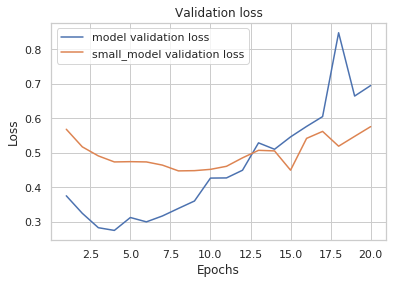

In [6]:
for name, record in zip(["model", "small_model"],[history, small_history]):
  history_dict = record.history
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(val_loss_values) +1)

  plt.plot(epochs, val_loss_values, label=f"{name} validation loss")
  
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
# Let's try a bigger model
# Smaller model
big_model = keras.models.Sequential()
big_model.add(keras.layers.Dense(512, activation="relu", input_shape=(10000,)))
big_model.add(keras.layers.Dense(512, activation="relu"))
big_model.add(keras.layers.Dense(1, activation="sigmoid"))
big_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

big_history = big_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 10s 689us/step - loss: 0.5618 - acc: 0.7706 - val_loss: 0.2965 - val_acc: 0.8834
Epoch 2/20
15000/15000 [==============================] - 10s 666us/step - loss: 0.2554 - acc: 0.8974 - val_loss: 0.2683 - val_acc: 0.8895
Epoch 3/20
15000/15000 [==============================] - 10s 658us/step - loss: 0.1487 - acc: 0.9449 - val_loss: 0.5288 - val_acc: 0.7931
Epoch 4/20
15000/15000 [==============================] - 10s 653us/step - loss: 0.0866 - acc: 0.9702 - val_loss: 0.4014 - val_acc: 0.8805
Epoch 5/20
15000/15000 [==============================] - 10s 658us/step - loss: 0.1155 - acc: 0.9759 - val_loss: 0.3152 - val_acc: 0.8864
Epoch 6/20
15000/15000 [==============================] - 10s 658us/step - loss: 0.0054 - acc: 0.9997 - val_loss: 0.4953 - val_acc: 0.8876
Epoch 7/20
15000/15000 [==============================] - 10s 657us/step - loss: 6.3674e-04 - acc: 1.0000 - val_loss

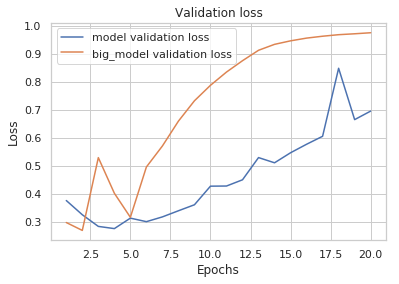

In [8]:
for name, record in zip(["model", "big_model"],[history, big_history]):
  history_dict = record.history
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(val_loss_values) +1)

  plt.plot(epochs, val_loss_values, label=f"{name} validation loss")
  
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

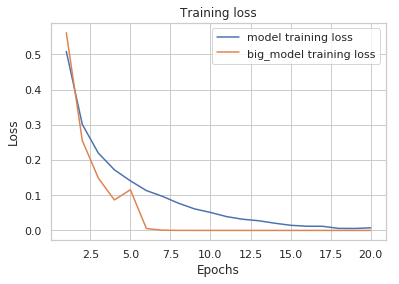

In [9]:
for name, record in zip(["model", "big_model"],[history, big_history]):
  history_dict = record.history
  loss_values = history_dict["loss"]
  epochs = range(1, len(loss_values) +1)

  plt.plot(epochs, loss_values, label=f"{name} training loss")
  
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Weight regularisation

By reducing the entropy of the distribution of parameter values (e.g. making them more regular), we force the model to be simpler. We do this by adding some cost to the loss function associated with the weights. E.g.:
- L1 regularisation:  cost is proportional to the absolute value of the weights
- L2 regularisation: cost is proportional to the squares of the weights.

In [10]:
# Add regularisers to the movie-review classifier
l2_model = keras.models.Sequential()
# We could also use "l1" or "l1_l2" 
l2_model.add(keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                                activation="relu", input_shape=(10000,)))
l2_model.add(keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                                activation="relu"))
l2_model.add(keras.layers.Dense(1, activation="sigmoid"))
l2_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

l2_history = l2_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 170us/step - loss: 0.5706 - acc: 0.7880 - val_loss: 0.4879 - val_acc: 0.8212
Epoch 2/20
15000/15000 [==============================] - 2s 128us/step - loss: 0.3779 - acc: 0.8956 - val_loss: 0.3715 - val_acc: 0.8753
Epoch 3/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.2970 - acc: 0.9186 - val_loss: 0.3354 - val_acc: 0.8889
Epoch 4/20
15000/15000 [==============================] - 2s 123us/step - loss: 0.2567 - acc: 0.9301 - val_loss: 0.3365 - val_acc: 0.8831
Epoch 5/20
15000/15000 [==============================] - 2s 124us/step - loss: 0.2350 - acc: 0.9397 - val_loss: 0.3445 - val_acc: 0.8823
Epoch 6/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.2192 - acc: 0.9468 - val_loss: 0.3345 - val_acc: 0.8838
Epoch 7/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.2050 - acc: 0.9524 - val_loss: 0.3415 - 

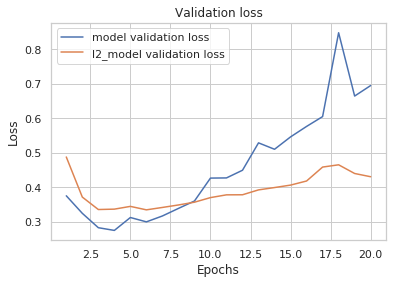

In [11]:
for name, record in zip(["model", "l2_model"],[history, l2_history]):
  history_dict = record.history
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(val_loss_values) +1)

  plt.plot(epochs, val_loss_values, label=f"{name} validation loss")
  
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Dropout

Randomly set a number of output features of the layer to zero during training (apparently a rate between 0.2 and 0,5 is common).
At test time, instead of dropping features the layer's output values are scaled down by the dropout rate.

In [12]:
# Add dropout to the movie-review classifier
dropout_model = keras.models.Sequential()
# We could also use "l1" or "l1_l2" 
dropout_model.add(keras.layers.Dense(16, activation="relu", input_shape=(10000,)))
dropout_model.add(keras.layers.Dropout(0.5))
dropout_model.add(keras.layers.Dense(16, activation="relu"))
dropout_model.add(keras.layers.Dropout(0.5))
dropout_model.add(keras.layers.Dense(1, activation="sigmoid"))
dropout_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

dropout_history = dropout_model.fit(partial_X_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=0)

W0614 18:40:55.670091 139987608426368 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


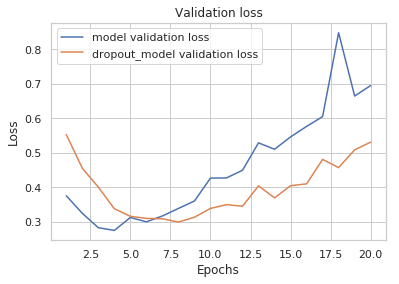

In [13]:
for name, record in zip(["model", "dropout_model"],[history, dropout_history]):
  history_dict = record.history
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(val_loss_values) +1)

  plt.plot(epochs, val_loss_values, label=f"{name} validation loss")
  
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()